In [1]:
import timeit
import scipy.io as sio
import scipy
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
rn.seed(123)
np.random.seed(123)
set_random_seed(123)
tf.set_random_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
from keras import backend as K
K.set_session(sess)
import pandas as pd
from pathlib import Path
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\hys19\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def import_skeleton_data(action, subject, trial):
    filename = f'Kinect2Dataset/Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_skel']
    else:
        return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df

In [3]:
# Read in all data
trial_end = 4
activity_end = 27
subject_end = 8

master_df = pd.DataFrame({'action': [], 'subject': [], 'trial': [], 'frame': [], 'skeleton_joint':[], 'x':[], 'y':[], 'z':[]})

for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp_df = transform_skeleton_data_to_df(activity, subject, trial)
            master_df = pd.concat([master_df, temp_df])

In [4]:
# Transpose skeleton_joint column
for skeleton in list(master_df.skeleton_joint.unique()):
    temp_df_by_skel = master_df.loc[master_df['skeleton_joint'] == skeleton]
    temp_df_by_skel = temp_df_by_skel.rename(columns={'x': 'x'+str(int(skeleton)), 
                                                      'y': 'y'+str(int(skeleton)), 
                                                      'z': 'z'+str(int(skeleton))})
    temp_df_by_skel = temp_df_by_skel.drop(['skeleton_joint'], axis=1)
    if skeleton == 1.0:
        transformed = temp_df_by_skel
    else:
        transformed = transformed.merge(temp_df_by_skel, on=['action','subject','trial','frame'], how='left')
transformed = transformed.sort_values(by=['action','subject','trial','frame'])

In [5]:
# Prepare data for training: Zero padding to ensure sequences are of equal length, Data partition (70%-30%)
finalX = []
finaly = []
for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp = transformed.loc[(transformed['action'] == activity) & 
                                   (transformed['subject'] == subject) &
                                   (transformed['trial'] == trial)]
            tempX = temp.filter(regex='[xyz].*')
            tempX = tempX.values
            tempy = temp['action'].values[0]
            finaly.append(tempy)
            npad = ((125-tempX.shape[0], 0), (0, 0))
            tempX = np.pad(tempX, pad_width=npad, mode='constant', constant_values=0)
            finalX.append(tempX)
            
finalX = np.stack(finalX)
finaly = np.stack(finaly)
finaly = to_categorical(finaly)

X_train, X_test, y_train, y_test = train_test_split(finalX, finaly, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 125, 60), (260, 125, 60), (604, 28), (260, 28))

In [6]:
# LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                22200     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1428      
Total params: 23,628
Trainable params: 23,628
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Stop training when validation loss doesn't improve after 30 epochs
# Save the best model in terms of validation loss
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
mcp_save = ModelCheckpoint('Skeleton model files/LSTM_skeleton_rawcoords.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [9]:
start_time = timeit.default_timer()
LSTMRaw_Hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10000, batch_size=32, callbacks=[earlyStopping, mcp_save])
elapsed = timeit.default_timer() - start_time
print("Time taken: " + str(elapsed) + "s")
model.load_weights('Skeleton model files/LSTM_skeleton_rawcoords.hdf5')

Train on 604 samples, validate on 260 samples
Epoch 1/10000
604/604 [==============================] - 4s 6ms/step - loss: 3.3332 - acc: 0.0414 - val_loss: 3.3373 - val_acc: 0.0654
Epoch 2/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.3082 - acc: 0.0331 - val_loss: 3.3284 - val_acc: 0.0308
Epoch 3/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.3004 - acc: 0.0364 - val_loss: 3.3260 - val_acc: 0.0192
Epoch 4/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.2896 - acc: 0.0414 - val_loss: 3.3149 - val_acc: 0.0654
Epoch 5/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.2783 - acc: 0.0646 - val_loss: 3.3044 - val_acc: 0.0538
Epoch 6/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.2513 - acc: 0.0894 - val_loss: 3.2894 - val_acc: 0.0808
Epoch 7/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.2397 - acc: 0.0911 - val_loss: 3.2603 - val_acc: 0.0769
Epoch 8/1

Epoch 61/10000
604/604 [==============================] - 3s 5ms/step - loss: 1.6622 - acc: 0.4520 - val_loss: 1.7730 - val_acc: 0.3500
Epoch 62/10000
604/604 [==============================] - 3s 5ms/step - loss: 1.6216 - acc: 0.4652 - val_loss: 1.6571 - val_acc: 0.3923
Epoch 63/10000
604/604 [==============================] - 3s 5ms/step - loss: 1.5333 - acc: 0.4785 - val_loss: 1.6288 - val_acc: 0.4115
Epoch 64/10000
604/604 [==============================] - 3s 4ms/step - loss: 1.4864 - acc: 0.5149 - val_loss: 1.5999 - val_acc: 0.4154
Epoch 65/10000
604/604 [==============================] - 3s 4ms/step - loss: 1.5781 - acc: 0.4669 - val_loss: 1.6476 - val_acc: 0.4077
Epoch 66/10000
604/604 [==============================] - 3s 5ms/step - loss: 1.5444 - acc: 0.4917 - val_loss: 1.6570 - val_acc: 0.3808
Epoch 67/10000
604/604 [==============================] - 3s 5ms/step - loss: 1.5018 - acc: 0.4735 - val_loss: 1.6053 - val_acc: 0.3923
Epoch 68/10000
604/604 [========================

604/604 [==============================] - 3s 4ms/step - loss: 1.0977 - acc: 0.6093 - val_loss: 1.2371 - val_acc: 0.5385
Epoch 122/10000
604/604 [==============================] - 3s 4ms/step - loss: 1.1190 - acc: 0.5960 - val_loss: 1.1814 - val_acc: 0.5423
Epoch 123/10000
604/604 [==============================] - 2s 4ms/step - loss: 1.2194 - acc: 0.5430 - val_loss: 1.2750 - val_acc: 0.5038
Epoch 124/10000
604/604 [==============================] - 2s 4ms/step - loss: 1.1277 - acc: 0.5993 - val_loss: 1.3160 - val_acc: 0.5115
Epoch 125/10000
604/604 [==============================] - 2s 4ms/step - loss: 1.1223 - acc: 0.6010 - val_loss: 1.1671 - val_acc: 0.5385
Epoch 126/10000
604/604 [==============================] - 2s 4ms/step - loss: 1.0141 - acc: 0.6308 - val_loss: 1.1485 - val_acc: 0.5577
Epoch 127/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.9795 - acc: 0.6556 - val_loss: 1.1208 - val_acc: 0.5808
Epoch 128/10000
604/604 [==============================] 

Epoch 181/10000
604/604 [==============================] - 2s 4ms/step - loss: 1.0260 - acc: 0.6225 - val_loss: 1.1015 - val_acc: 0.5654
Epoch 182/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.9483 - acc: 0.6457 - val_loss: 0.9969 - val_acc: 0.6538
Epoch 183/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.7948 - acc: 0.7169 - val_loss: 0.9028 - val_acc: 0.6731
Epoch 184/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.7520 - acc: 0.7169 - val_loss: 0.9437 - val_acc: 0.6346
Epoch 185/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.8041 - acc: 0.7169 - val_loss: 0.9711 - val_acc: 0.6538
Epoch 186/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.8081 - acc: 0.6987 - val_loss: 0.9276 - val_acc: 0.6500
Epoch 187/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.8301 - acc: 0.6921 - val_loss: 1.3623 - val_acc: 0.4500
Epoch 188/10000
604/604 [================

Epoch 241/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.7035 - acc: 0.7417 - val_loss: 0.9082 - val_acc: 0.6385
Epoch 242/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.6735 - acc: 0.7401 - val_loss: 0.8152 - val_acc: 0.6692
Epoch 243/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.6355 - acc: 0.7550 - val_loss: 0.8037 - val_acc: 0.6577
Epoch 244/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.6101 - acc: 0.7632 - val_loss: 0.7869 - val_acc: 0.7077
Epoch 245/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.6989 - acc: 0.7219 - val_loss: 0.9856 - val_acc: 0.6269
Epoch 246/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.7053 - acc: 0.7219 - val_loss: 0.8254 - val_acc: 0.6885
Epoch 247/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.6618 - acc: 0.7467 - val_loss: 0.6941 - val_acc: 0.7077
Epoch 248/10000
604/604 [================

Epoch 301/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.8640 - acc: 0.6937 - val_loss: 0.9275 - val_acc: 0.6538
Epoch 302/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.7007 - acc: 0.7351 - val_loss: 0.7079 - val_acc: 0.7308
Epoch 303/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.5941 - acc: 0.7616 - val_loss: 0.7030 - val_acc: 0.6962
Epoch 304/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.5273 - acc: 0.7980 - val_loss: 0.6253 - val_acc: 0.7577
Epoch 305/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.5090 - acc: 0.8129 - val_loss: 0.6293 - val_acc: 0.7385
Epoch 306/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.4894 - acc: 0.8245 - val_loss: 0.6294 - val_acc: 0.7346
Epoch 307/10000
604/604 [==============================] - 2s 4ms/step - loss: 0.4693 - acc: 0.8278 - val_loss: 0.6308 - val_acc: 0.7692
Epoch 308/10000
604/604 [================

Epoch 361/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.3869 - acc: 0.8642 - val_loss: 0.6031 - val_acc: 0.7846
Epoch 362/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.3936 - acc: 0.8675 - val_loss: 0.5737 - val_acc: 0.7885
Epoch 363/10000
604/604 [==============================] - 3s 5ms/step - loss: 0.3903 - acc: 0.8692 - val_loss: 0.6240 - val_acc: 0.7615
Epoch 364/10000
604/604 [==============================] - 3s 5ms/step - loss: 0.4503 - acc: 0.8394 - val_loss: 0.5901 - val_acc: 0.7885
Epoch 365/10000
604/604 [==============================] - 3s 5ms/step - loss: 0.4189 - acc: 0.8543 - val_loss: 0.6227 - val_acc: 0.7577
Epoch 366/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.3997 - acc: 0.8526 - val_loss: 0.5698 - val_acc: 0.7769
Epoch 367/10000
604/604 [==============================] - 3s 4ms/step - loss: 0.3757 - acc: 0.8642 - val_loss: 0.5435 - val_acc: 0.8077
Epoch 368/10000
604/604 [================

In [10]:
scores = model.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 90.07%
Test Accuracy: 79.23%


In [11]:
predictions = model.predict(X_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       0.88      0.88      0.88         8
      Swipe Right       0.92      1.00      0.96        11
             Wave       0.42      0.67      0.52        12
             Clap       0.60      0.25      0.35        12
            Throw       0.55      1.00      0.71         6
        Arm Cross       0.67      1.00      0.80         8
 Basketball Shoot       1.00      0.67      0.80         9
           Draw X       0.92      0.92      0.92        12
 Draw Circle (CW)       0.67      0.75      0.71         8
Draw Circle (CCW)       0.33      0.10      0.15        10
    Draw Triangle       0.38      0.62      0.48         8
          Bowling       1.00      1.00      1.00         9
           Boxing       1.00      0.88      0.93         8
   Baseball Swing       1.00      0.91      0.95        11
     Tennis Swing       1.00      1.00      1.00         5
         Arm Curl       0.59      0.77      0.67       

In [12]:
#from keras.models import load_model
#model = load_model('LSTM_skeleton_rawcoords.hdf5')

In [13]:
with open('Skeleton model files/LSTMRaw_Hist', 'wb') as file:
    pickle.dump(LSTMRaw_Hist.history, file)

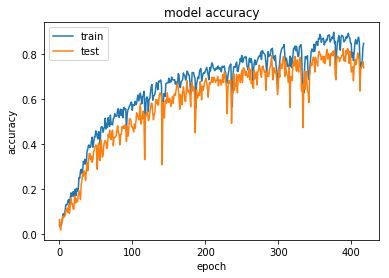

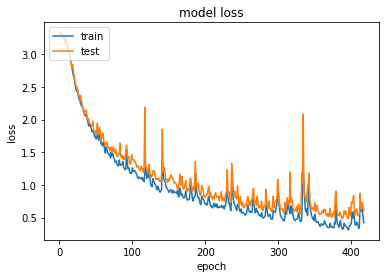

In [14]:
# summarize history for accuracy
plt.plot(LSTMRaw_Hist.history['acc'])
plt.plot(LSTMRaw_Hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LSTMRaw_Hist.history['loss'])
plt.plot(LSTMRaw_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()